# Discover a newspaper collection with diachronic Ngram clouds




Ngrams are contiguous  sequences of n items from a given text or speech sample. This means that words are not considered as individual units, but in relation to each other. For scholars in the humanities, ngrams can be helpful to get an overview of their collection or to identify discourse markers (discourse = a group of related texts belonging to a common system of formation). Ngrams can never be a research result per se - which is true for any output of NLP methods - but they can help to find important patterns in a particular collection.  

When ngrams are used to identify discourse markers, it may be useful to create diachronic ngrams to study the change of textual patterns. This notebook therefore shows how diachronic ngrams can be constructed and visualized. For cultural heritage material, visualizations should make it possible to access and experience the collections in new ways. However, they should always be linked to the original documents. 

The graphic representation and the original material cannot be perceived as two different elements, they are rather  interwoven and interact with each other. Therefore, this Notebook allows to browse the original texts within the Notebook. Thus the results of the ngram clouds can be researched in the context of the original text. 

Acknowledgments:

This work was supported by the European Union's Horizon 2020 research and innovation programme under grant 770299 (NewsEye).

## Step by step...
* [Prepare your collection](#1-bullet)
* [Install packages in command line](#2-bullet)
* [Import packages](#3-bullet)
* [Import your collection](#4-bullet)
* [Clean and tokenize the text (pre-processing)](#5-bullet)
* [LLemmatization and pos tagging](#6-bullet)
* [Have a look at your collection - Create an onegram, bigram or trigram](#7-bullet)
* [Discover diachronic n-grams for specific years or time periods](#8-bullet)
* [Browse original texts](#9-bullet)


## Prepare your collection <a class="anchor" id="1-bullet"></a>

Your collection should at least contain the original text and information on the date of origin. 

## Install packages in command line <a class="anchor" id="2-bullet"></a>
 
If you need help on how to pip install, have a look at this tutorial: https://packaging.python.org/tutorials/installing-packages/

pip install gensim

pip install PyLDAvis

pip install spacy

python -m spacy download de_core_web_sm

pip install pandas

pip install regex

pip install nltk

pip install matplotlib

pip install numpy

## Import packages <a class="anchor" id="3-bullet"></a>

Before you can get started, you have to install and import some packages.

In [2]:
#languange processing imports
import gensim, spacy, logging, warnings
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from nltk.stem.porter import PorterStemmer
#from gensim.utils import lemmatize, simple_preprocess

#For the text overview
from nltk import FreqDist

#Word Cloud and Visualization

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

## Import your newspaper collection <a class="anchor" id="2-bullet"></a>
And have a look at your data

In [3]:
df = pd.read_csv('Data/y_t_sudtirol.csv', encoding='latin-1')

In [4]:
df

,year,Newspaper,text
0,1945,Das kleine Volksblatt,den Es wird al» unwahrscheinlich bezeichnet d...
1,1945,Das kleine Volksblatt,waffnungösterreichs die Brennergrenze ihre mi...
2,1945,Das kleine Volksblatt,z n g e b e n Außerdem wird Bachner das Verbr...
3,1945,Das kleine Volksblatt,Bacher sabotierte damit die Anvrdnungen des S...
4,1945,Das kleine Volksblatt,Telephon A 23540 Wien Samstag den 8 September...
...,...,...,...
4030,1948,Wiener Kurier,fen Tel B 27-1-73 U Klnder-Zwei- und -Drei rä...
4031,1948,Wiener Kurier,1-t-LKW und 1 amerikanischer Luxuswagen beide...
4032,1948,Wiener Kurier,eisenbeschlagenem Plateau neuwertig Zu besich...
4033,1948,Wiener Kurier,Der italienische Außenminister Graf Sforza un...


<Figure size 1440x3600 with 0 Axes>

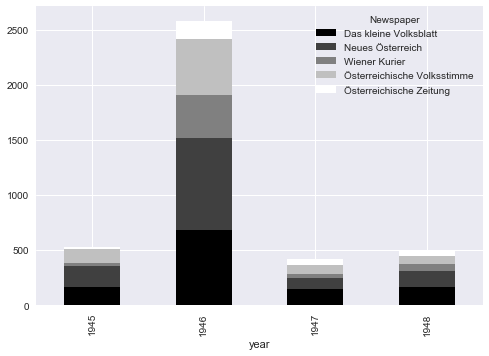

In [41]:
fig = plt.figure(figsize=(20,50))
plt.style.use('seaborn')
fig = df.groupby(['year','Newspaper']).size().unstack().plot(kind='bar',stacked=True, colormap=plt.cm.gray)
plt.savefig('bar.png', dpi = 300)


## Clean and tokenize the text (pre-processing) <a class="anchor" id="5-bullet"></a>

Before you can start to train the bigram and trigram models, you have to clean the text of your newspaper text blocks. The follwing functions remove punctuations, lower case the text, remove stop words and stem the text. 

#### Stop words: 
You can change the language used for the stop words. You can also add your own stop words or other words you would like to ignore. It helps to ignore your search keywords as well as keywords that are overly representative.

In [5]:
# Functions to clean, tokenize, and stem the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your own stop words
stop_words.extend(['italienisch', 'italien', 'italienische', 'italienischen', 'österreich', 'österreichische','österreichischen', 'österreichisch', 'österreichs', 'südtirolerplatz', 'südtriol'])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [6]:
df['tokenized'] = df['text'].apply(apply_all) 

## Have a look at your collection - Create an onegram, bigram or trigram <a class="anchor" id="7-bullet"></a>

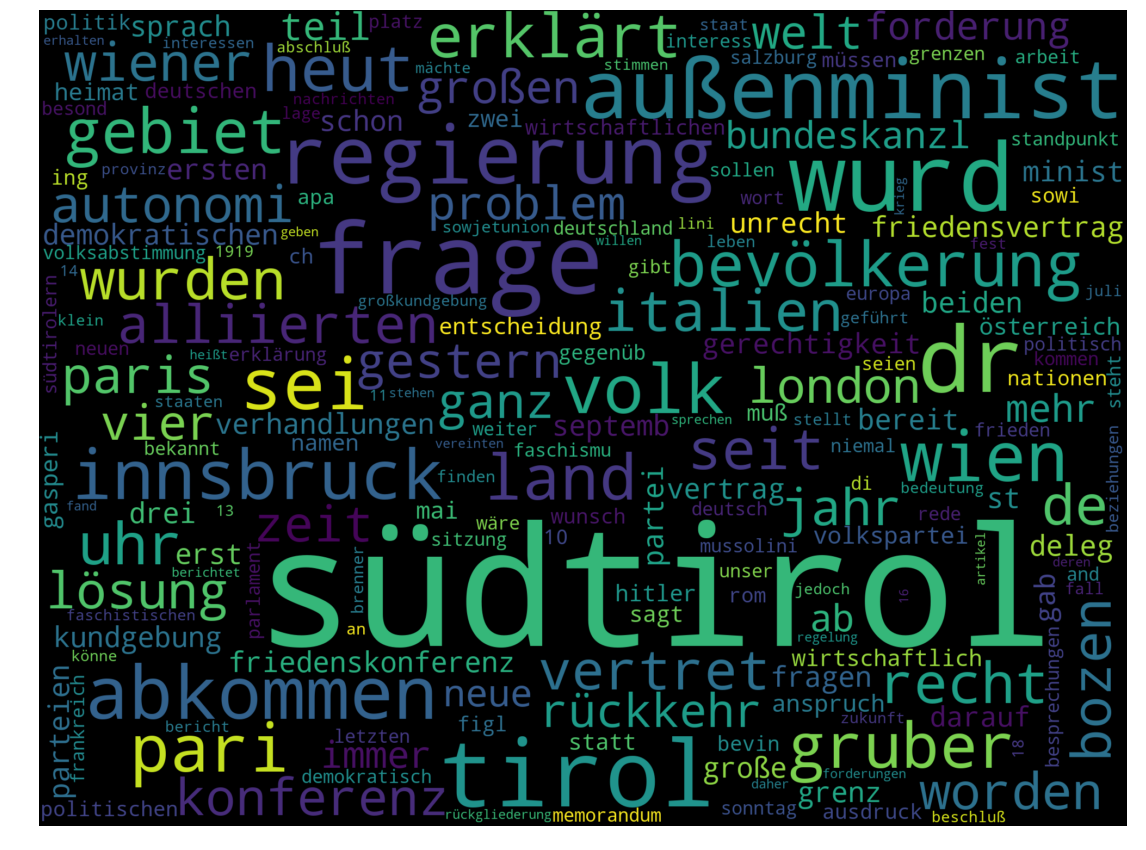

In [7]:
bigrams_list = list(nltk.bigrams(df['tokenized']))
dictionary = [' '.join([str(tup) for tup in bigrams_list])]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(dictionary)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)
WC_height = 1500
WC_width = 2000
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(20, 15))
plt.plot
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Lemmatization and pos tagging<a class="anchor" id="6-bullet"></a>


We reduce the data to nouns, adjectives, verses and opponents. The package Spacy is used for the pos tagging. Spacy can be used in many differnt languages. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models. 

We lemmatize the text and remove stop words once more after lemmatization. 


In [8]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts_out = []
    nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out
    # remove stopwords once more after lemmatization


data_ready1 = process_words(df['tokenized'])  # processed Text Data!

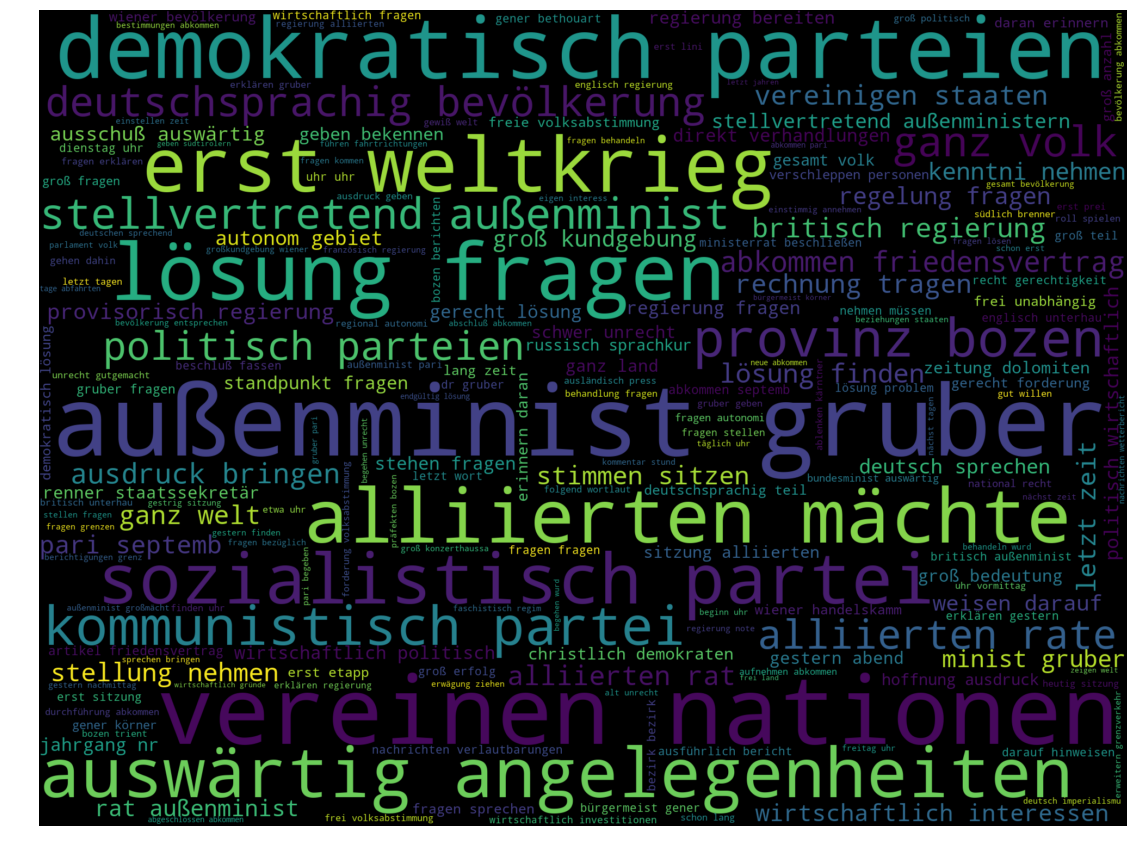

In [9]:
bigrams_list = list(nltk.bigrams(data_ready1))
dictionary = [' '.join([str(tup) for tup in bigrams_list])]
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)
WC_height = 1500
WC_width = 2000
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(20, 15))
plt.plot
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Check the word frequency in numbers: 

In [10]:
bigrams_list = list(nltk.bigrams(data_ready1))
dictionary = [' '.join([str(tup) for tup in bigrams_list])]
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)
print(words_freq[0:50])

[('außenminist gruber', 126), ('vereinen nationen', 116), ('demokratisch parteien', 90), ('lösung fragen', 80), ('erst weltkrieg', 73), ('alliierten mächte', 72), ('sozialistisch partei', 62), ('auswärtig angelegenheiten', 62), ('kommunistisch partei', 50), ('provinz bozen', 48), ('stellvertretend außenminist', 46), ('ganz volk', 44), ('deutschsprachig bevölkerung', 44), ('alliierten rate', 44), ('politisch parteien', 42), ('abkommen friedensvertrag', 41), ('ausdruck bringen', 40), ('alliierten rat', 38), ('vereinigen staaten', 38), ('britisch regierung', 38), ('lösung finden', 37), ('ganz welt', 36), ('rechnung tragen', 36), ('stellung nehmen', 34), ('letzt zeit', 34), ('stimmen sitzen', 34), ('pari septemb', 32), ('regelung fragen', 30), ('kenntni nehmen', 30), ('minist gruber', 30), ('wirtschaftlich interessen', 29), ('groß kundgebung', 28), ('rat außenminist', 28), ('provisorisch regierung', 26), ('weisen darauf', 26), ('stellvertretend außenministern', 26), ('deutsch sprechen', 26

## Discover diachronic n-grams for specific years or time periods <a class="anchor" id="8-bullet"></a>

Here you can create diachronic Ngram clouds for specific years or time frames. 

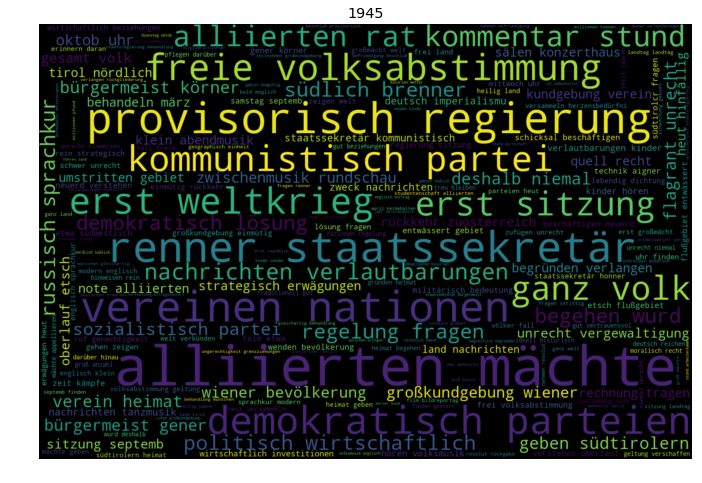

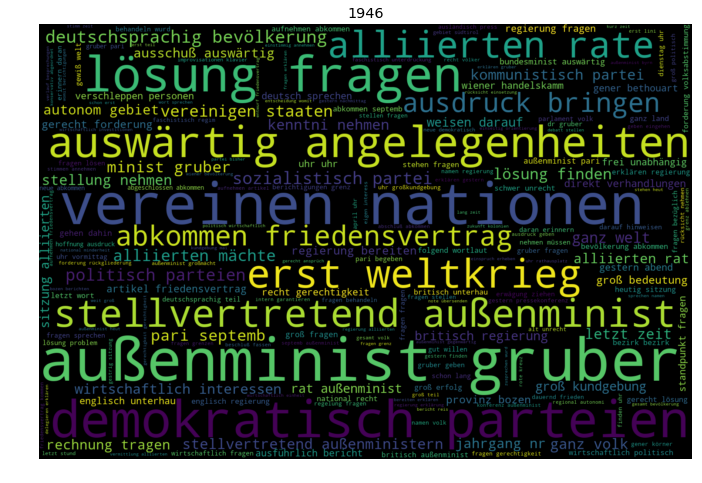

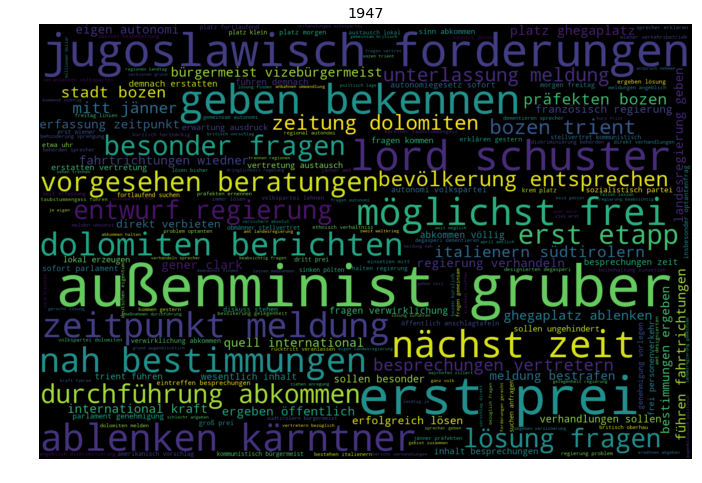

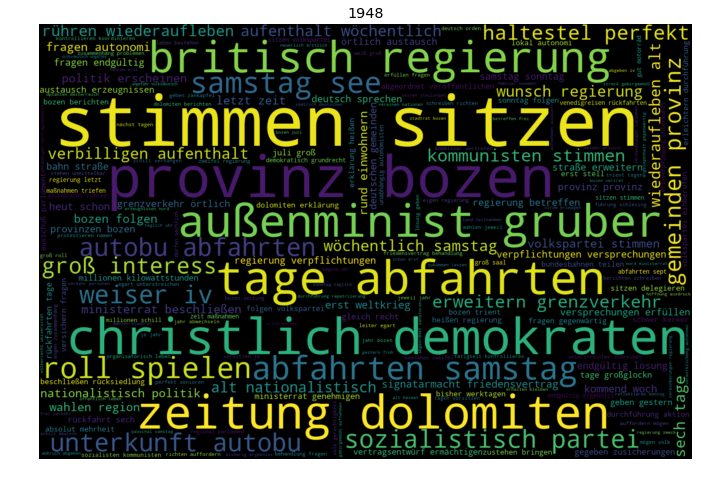

In [11]:
#Choose specific years or time frames you want to use for the NGram clouds
_1945 = (df['year'] > int('1944')) & (df['year'] <= int('1945'))
_1946 = (df['year'] > int('1945')) & (df['year'] <= int('1946'))
_1947 = (df['year'] > int('1946')) & (df['year'] <= int('1947'))
_1948 = (df['year'] > int('1947')) & (df['year'] <= int('1948'))

#This will be used for the title of the clouds
time_frame = ['1945', '1946', '1947', '1948']

#Here you create a list containing the information on your selected time-frames
selection = []
selection.append(_1945)
selection.append(_1946)
selection.append(_1947)
selection.append(_1948)

#Get your bigrams for every selected time frame
selection[0] = df.loc[_1945]['tokenized']
selection[1] = df.loc[_1946]['tokenized']
selection[2] = df.loc[_1947]['tokenized']
selection[3] = df.loc[_1948]['tokenized']
#Create the diachronic Ngram clouds
i = -1
while i < len(selection) -1:
    i = i +1 
    data_ready3 = process_words(selection[i])  # processed Text Data!
    bigrams_list = list(nltk.bigrams(data_ready3))
    dictionary = [' '.join([str(tup) for tup in bigrams_list])]
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    WC_height = 1000
    WC_width = 1500
    WC_max_words = 200
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize=(15, 8))
    plt.plot
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(time_frame[i], size= 'x-large')
    plt.axis("off")
    plt.savefig('cloud.png', dpi = 300)
print()

## Browse original texts <a class="anchor" id="9-bullet"></a>

Here you can browse through the original text. To refine the search, you can reduce the search to those texts that contain a specific word. In this example all texts were searched containg the word "amerika*". 

In [12]:
pd.set_option('display.max_colwidth', -1)

lines_ = []
for line in df['text']:
    if 'Wirtschaft' in line:
        lines_.append(line)
    
lines_ = pd.DataFrame(lines_, columns =['text'])
df_select = pd.DataFrame(lines_['text'])
df_select[0:100]    


C:\Users\c62255\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,text
0,appellieren an die italienischen demokratischen Parteien den Faschismus mich auf dem Gebiet der zwischenstaatlichen Beziehungen zu liqui dieren und sich nicht gegen die Rückgliederung Südtirols zu wenden die dem einigen Willen der Südtiroler Bevölkerung entspricht Wenn diese schwärende Wunde die die Beziehungen zwischenösterreich und Italien dauernd ver giftet hat geheilt ist steht einer möglichst engen Wirtschaftlichen und politischen Verbindung der beiden Länder nichts mehr im Wege
1,M^er anderem-auch die wie das amerikanische Durch ferne eigenartige geschichtliche Entwicklung war Volk überösterreichs Mitschuld am Tirol zu einer festgefügten historischen und Wirtschaft
2,Ordnung bereit die den Interessen der italienischen Wirtschaft voll Rechnung trägt Der Landeshauptmann schloß mit einem
3,heute 715: Frühkonzert 755: Ratgeber 800 bis 815: Wiener Verlautbarungen 1200: Mittagskonzert 1230: Nachrichten Wetterbericht und Programm für heute 1245: Presseschau 1300: Fortsetzung des Mittagskonzerts 1400 bis 1416: Wiener Verlautbarungen 1415 bis 1600: Versuchssendungen für technische Zwecke 1600: Nachmittagskonzert 1700: Nachrichten und Verlautbarungen 1710: Kinder senden  Kinder hören 1730: Volksmusik aus österreich 1755: Englischer Vortrag über Südtirol 1800: Für die Jugend: Der PiratenkönigH Erlebnisbericht von Oskar Schlosser 1825: 80 Jahre Straßenbahn in Wien 1840: Zwischenmusik 1850: Die Rundschau Rundschaureporter debattieren über Kalorien und über das Wetter 1900: Der Kommentar 1905: Stunde der Wirtschaft: österreichische Industrie im Lichte der Gegenwart Es spricht Dr Hans Lauda 1915: Russischer Sprachkurs 1930: Kleine Abendmusik 2000: Nachrichten und Programm für den
4,"Verlautbarungen- 1415 bis 1600: Versuchssendungen für technische Zwecke- 16-00: Nachmittagskonzert 1700: Nachrichten imd Verlautbarungen 1710: Kinder senden  Kinder hören 1730: Volksmusik aus österreich- 1755: Englischer Vortrag über Südtirol 1600: Für die Jugend: Der Piratenkönig"" Erlebnisbericht von Oskar Schlosser 1825: Achtzig Jahre Straßenbahn in Wien- 1840: Zwischenmusik 1850: Die Rundschau Rundschaureporter debattieren über Kalorien und über das Wetter 19-00: Der Kommentar 1905: Stunde der Wirtschaft: österreichische Industrie im Lichte der Gegenwart 1916: Russischer Sprachkurs 1930: Kleine Abendmusik"
...,...
74,einer Versammlung der Industriellenvereinigung in Linz Der österreichische Wirtschaftsverkehr mit Italien basiere gegenwärtig auf einem schon zwei Jahre alten Vertrag der in verschiedenen Punkten einer Neuregelung bedürfe Die Verträge über Südtirol die in der nächsten Woche unterzeichnet würden brächten wertvolle Erleichterungen für den Wirtschaftsverkehr mit dem südlichen Nachbar Verhandlungen mit Argentinien seien geplant doch könnte das genaue Datum für die Aufnahme der Besprechungen noch nicht mit
75,Rom 29 Dezember Die österreichisch-italienischen Besprechungen über den Abschluß des Handelsvertrages sowie die Durchführung des bevorzugten Warenverkehrs zwischen Nord- und Südtirol werden nach einer Mitteilung des italienischen Außenministeriums Abteilung für Wirtschaftsangelegenheiten Mitte Jänner wiederaufgenommen werden Das genaue Datum ist noch nicht festgesetzt Die Fragen des Warenaustausches die vor ###
76,"österreichs mit Schmugglerware muß es uns gelingen österreich auf allen nur möglichen Gebieten zu schaden und endlich wieder zu Fall zu bringen"" Als Leiter der Wirtschaftsgriippe'' errichtete Söhnart in Südtirol einen Meldßkopf und be- | Wien 15 April (PKP) Auf Initiative der Arbeiter und Angestellten der SEB Neusiedl die beschlossen am diesjährigen 1 Mai gemeinsam zu marschieren bildete sich in Zistersdorf gin zentrales Festkomitee"
77,"Nun wird ein Plan bekannt der wieder1' einmal zeigt worauf die österreichische Energiewirtschaft ausgerichtet'' werden soll Fürs erste wird die 220-kV-Leitung der Vorarlberger Illwerke einen Anschluß nach Mittelitalien erhalten andererseits soll die gegenwärtig in Norditalien errichtet